# Описание проекта
Заказчик этого исследования — сеть отелей «Как в гостях». 

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. 
Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.
Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. 
Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

# Бизнес-метрика и другие данные
Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

Стоимость номеров отеля:

категория A: за ночь — 1 000, разовое обслуживание — 400;

категория B: за ночь — 800, разовое обслуживание — 350;

категория C: за ночь — 600, разовое обслуживание — 350;

категория D: за ночь — 550, разовое обслуживание — 150;

категория E: за ночь — 500, разовое обслуживание — 150;

категория F: за ночь — 450, разовое обслуживание — 150;

категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

# Описание данных
В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:

`id` — номер записи;

`adults` — количество взрослых постояльцев;

`arrival_date_year` — год заезда;

`arrival_date_month` — месяц заезда;

`arrival_date_week_number` — неделя заезда;

`arrival_date_day_of_month` — день заезда;

`babies` — количество младенцев;

`booking_changes` — количество изменений параметров заказа;

`children` — количество детей от 3 до 14 лет;

`country` — гражданство постояльца;

`customer_type` — тип заказчика:

* `Contract` — договор с юридическим лицом;

* `Group` — групповой заезд;

* `Transient` — не связано с договором или групповым заездом;

* `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.

`days_in_waiting_list` — сколько дней заказ ожидал подтверждения;

`distribution_channel` — канал дистрибуции заказа;

`is_canceled` — отмена заказа;

`is_repeated_guest` — признак того, что гость бронирует номер второй раз;

`lead_time` — количество дней между датой бронирования и датой прибытия;

`meal` — опции заказа:

* `SC` — нет дополнительных опций;

* `BB` — включён завтрак;

* `HB` — включён завтрак и обед;

* `FB` — включён завтрак, обед и ужин.

`previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;

`previous_cancellations` — количество отменённых заказов у клиента;

`required_car_parking_spaces` — необходимость места для автомобиля;

`reserved_room_type` — тип забронированной комнаты;

`stays_in_weekend_nights` — количество ночей в выходные дни;

`stays_in_week_nights` — количество ночей в будние дни;

`total_nights` — общее количество ночей;

`total_of_special_requests` — количество специальных отметок.

# Работа с данными

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from scipy.stats import randint


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

import random


from sklearn.metrics import f1_score, roc_curve, confusion_matrix, roc_auc_score

In [61]:
RS = 4411 # random_state

In [62]:
# parameters

pd.set_option('display.max_columns', 220)
pd.set_option('mode.chained_assignment', None)

In [63]:
try:
   train = pd.read_csv('/datasets/hotel_train.csv')
   test = pd.read_csv('/datasets/hotel_test.csv') 
except:
   train = pd.read_csv('D:\Temp\Ya_Pr\hotel_train.csv')
   test = pd.read_csv('D:\Temp\Ya_Pr\hotel_test.csv') 
   

In [64]:
def first_look(data):
    display(data.info())
    print()
    display(data.describe())
    print()
    print('Дубликатов обнаружено: ', data.duplicated().sum())
    print()
    data.hist(figsize=(25, 15))
    plt.show()
    print()
    print('Размер датасета:', data.shape)
    print()
    print('Пропуски')
    print(data.isna().sum())
    display(data.sample(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000



Дубликатов обнаружено:  0



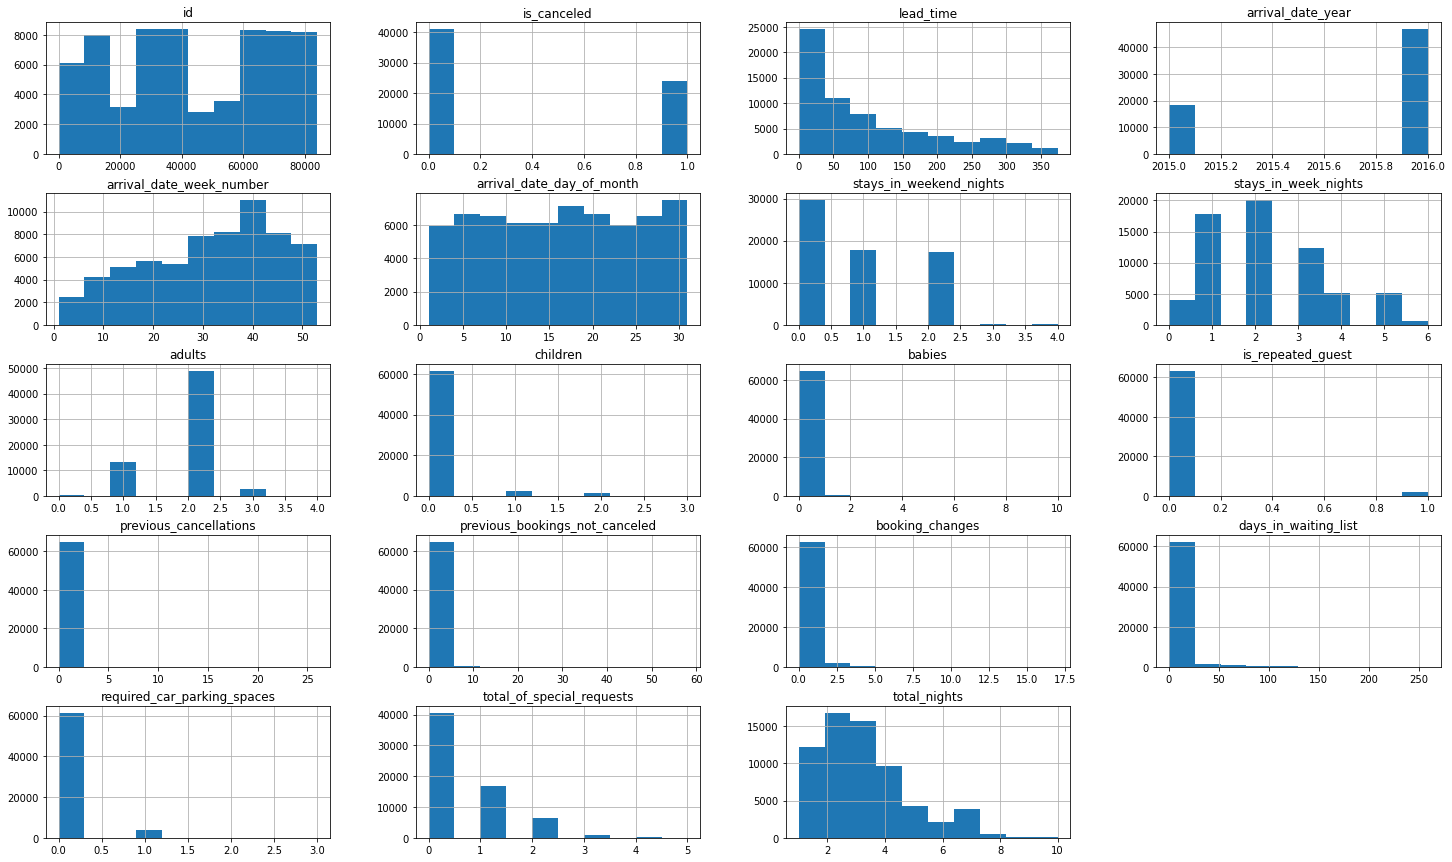


Размер датасета: (65229, 25)

Пропуски
id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
21390,29330,0,102.0,2015,October,42,16,0,2,2.0,0.0,0.0,HB,DEU,TA/TO,0,0,0,A,0,0,Transient-Party,0,0,2
16318,19119,0,0.0,2016,December,51,14,0,1,1.0,0.0,0.0,BB,PRT,Corporate,0,0,0,A,1,0,Transient,0,0,1
14381,17093,0,66.0,2016,September,38,17,2,1,2.0,0.0,0.0,BB,NLD,TA/TO,0,0,0,G,1,0,Transient,0,0,3
20924,28864,0,92.0,2015,October,41,6,0,5,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,1,0,Transient,0,1,5
295,301,0,65.0,2015,July,29,17,2,6,2.0,0.0,0.0,HB,ESP,TA/TO,0,0,0,A,0,0,Transient,0,2,8
43811,62237,1,146.0,2016,March,14,30,0,3,1.0,0.0,0.0,BB,PRT,TA/TO,0,1,0,A,0,28,Transient,0,0,3
28052,35992,0,316.0,2016,May,22,26,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient-Party,0,0,3
28124,36064,1,52.0,2016,May,22,28,2,2,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,D,0,0,Transient,0,0,4
48820,67313,0,50.0,2016,March,14,31,0,3,2.0,0.0,0.0,BB,ISR,TA/TO,0,0,0,A,0,0,Transient-Party,0,0,3
62124,80822,0,27.0,2016,October,44,28,2,2,2.0,0.0,0.0,SC,FRA,TA/TO,0,0,0,A,0,0,Transient,0,1,4


In [65]:
first_look(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000



Дубликатов обнаружено:  0



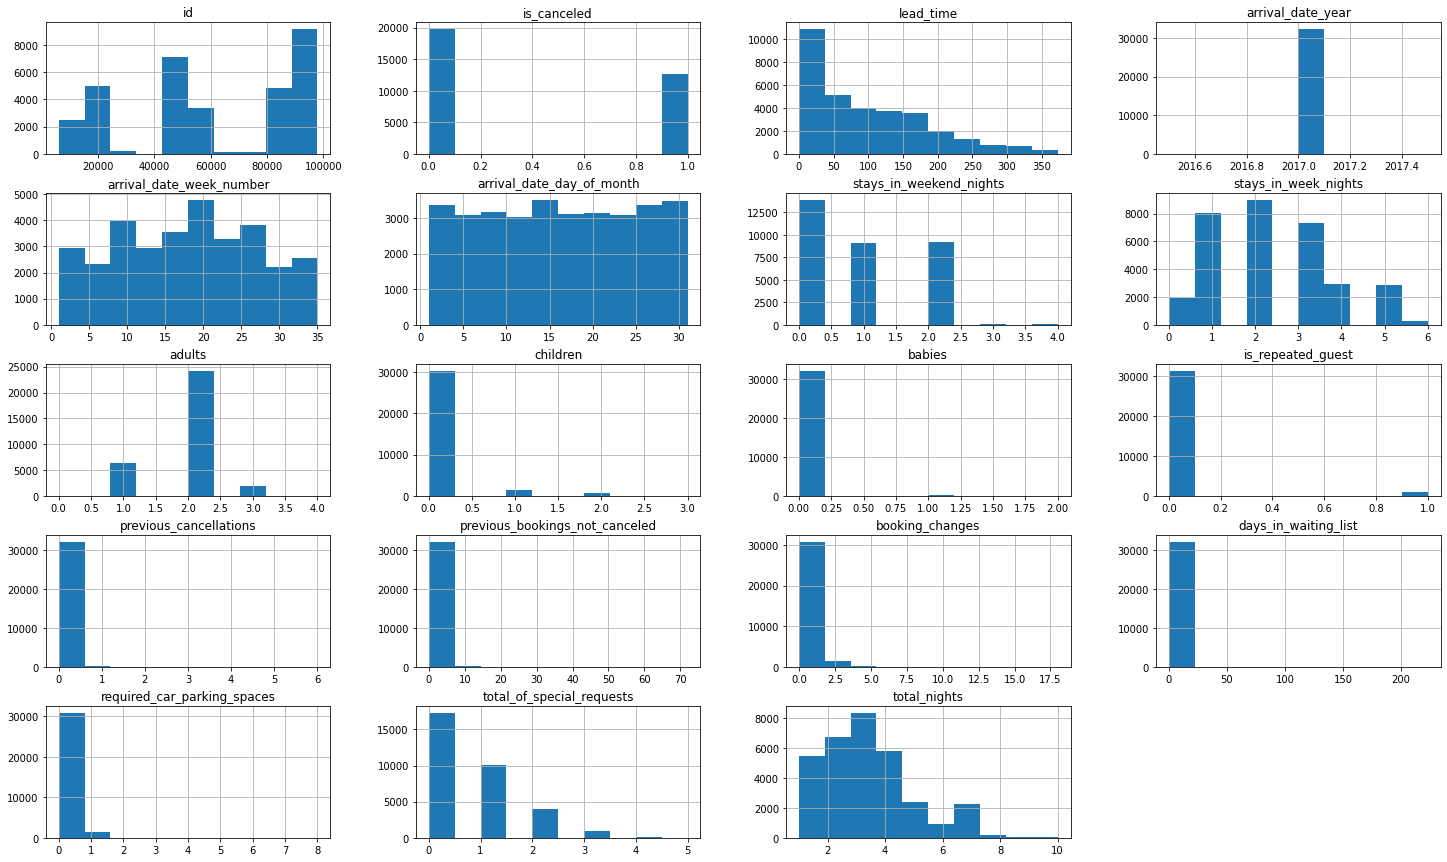


Размер датасета: (32412, 25)

Пропуски
id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
1279,7384,1,313.0,2017,May,21,27,2,5,2.0,0.0,0.0,BB,GBR,Direct,0,0,0,D,0,0,Transient,0,0,7
31542,97034,0,45.0,2017,August,33,16,0,3,3.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,D,0,0,Transient,0,0,3
24225,89717,0,70.0,2017,April,15,15,2,3,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,5
5836,22779,0,156.0,2017,May,19,8,2,5,2.0,0.0,0.0,HB,IRL,TA/TO,0,0,0,A,4,0,Transient-Party,0,1,7
22195,87687,0,20.0,2017,March,11,14,0,5,1.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,1,0,Transient,0,0,5
8098,45287,1,38.0,2017,January,2,14,0,1,1.0,0.0,0.0,BB,PRT,Corporate,0,0,0,A,0,0,Transient,0,0,1
1118,7220,1,302.0,2017,May,19,9,0,4,1.0,0.0,0.0,HB,PRT,Direct,0,0,0,A,0,0,Transient-Party,0,0,4
12508,49697,1,106.0,2017,May,18,1,1,5,2.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6
3145,20060,0,5.0,2017,January,4,25,0,1,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,D,0,0,Transient,0,2,1
10675,47864,1,76.0,2017,April,13,1,2,5,3.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,D,0,0,Transient,0,0,7


In [66]:
first_look(test)

## Краткий вывод

Данные загружены и бегло просмотрены.

Тренировочный датасет представляет данные за 2015—2016 гг., тестовый — за девять месяцев 2017 года.

Пропусков и явных дубликатов не обнаружено.

Выявленые проблемы:

1. Слишком большие значения максимумов по столбцам "babies", "previous_cancellations", "previous_bookings_not_canceled", "booking_changes", "days_in_waiting_list". 

2. Для машинного обучения присутствуют ненужные данные - столбы "id" и "arrival_date_year".

3. Необходимо кодирование категориальных переменных ("arrival_date_month", "meal", "country", "distribution_channel", "reserved_room_type", "customer_type").

4. Не указаны ценовые параметры по категориям номеров.

Более подробно исследуем данные далее.

# Исследовательский анализ данных

Проанализируем данные и приведем к адекватному для машинного обучения виду.

In [67]:
# Объединим датасеты для обработки. Обратное разделение проведем по году: test == 2017 и train != 2017

data = pd.concat([train, test]).reset_index(drop=True)
data

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97636,97899,0,164.0,2017,August,35,31,2,4,2.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6
97637,97900,0,21.0,2017,August,35,30,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7
97638,97901,0,23.0,2017,August,35,30,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7
97639,97902,0,34.0,2017,August,35,31,2,5,2.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7


In [68]:
data['id'].duplicated().sum()

0

In [69]:
# Уберем ненужные столбцы

#data = data.drop(['is_canceled', 'id'], axis=1)

categorized_cols = ['meal', 'country','distribution_channel', 'is_repeated_guest', 'required_car_parking_spaces', 'total_of_special_requests', 'reserved_room_type', 'booking_changes', 'customer_type']


In [70]:
# Уберем ненужные десятичные числа 
data = data.astype('int', errors='ignore')

In [71]:
months = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}

data['arrival_date_month'] = data['arrival_date_month'].map(months).astype('int')

In [72]:
data['babies'].unique()

array([ 0,  1,  2, 10,  9])

In [73]:
# 10 и 9 младенцев!  
display(data.query('babies > 3'))

# Ошибка в заполнении, вероятно. Удаляем строки, тем более их всего две

data = data.query('babies < 3')


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37,2016,1,3,12,0,2,2,0,10,BB,PRT,TA/TO,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11,2015,10,42,11,2,1,1,0,9,BB,GBR,Corporate,0,0,0,A,1,0,Transient-Party,0,0,3


In [74]:
# 
data.loc[data['babies'] > 0, 'babies'] = 1
data.rename(columns = {'babies':' has_babies'}, inplace = True )
data.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7,2015,7,27,1,0,1,1,0,0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14,2015,7,27,1,0,2,2,0,0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0,2015,7,27,1,0,2,2,0,0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9,2015,7,27,1,0,2,2,0,0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85,2015,7,27,1,0,3,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [75]:
# Отмененные заказы
data['previous_cancellations'].unique()

array([ 0,  1,  2,  3, 26, 25, 14, 24, 19,  4,  5, 21,  6, 13, 11])

In [76]:
data.query('previous_cancellations > 6').sort_values(ascending=False, by='previous_cancellations')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
6273,8602,1,275,2015,10,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6283,8612,1,275,2015,10,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6274,8603,1,275,2015,10,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6290,8619,1,275,2015,10,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
6289,8618,1,275,2015,10,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42787,61196,0,0,2016,1,3,14,0,1,2,0,0,BB,AUT,TA/TO,1,11,4,A,0,0,Transient,0,0,1
42788,61197,0,5,2016,1,3,14,0,2,1,0,0,BB,PER,TA/TO,1,11,4,A,0,0,Transient,0,1,2
42789,61198,0,4,2016,1,3,15,0,1,2,0,0,SC,FRA,TA/TO,1,11,5,A,0,0,Transient,0,1,1
42790,61199,0,8,2016,1,3,15,0,1,2,0,0,BB,PRT,TA/TO,1,11,5,A,0,0,Transient,0,1,1


In [77]:
data.drop(['id'], axis=1).query('previous_cancellations > 6').sort_values(ascending=False, by='previous_cancellations').duplicated().sum()

104

Как видим, значительное число строк с большим количеством отмен отличаются лишь `id`. 

Поскольку текущих данных недостаточно для того, чтобы точно указать причину отмены (а вариантов может быть масса, к примеру, нестабильное соединение с интернетом, не проходящая оплата, баловство etc), удалим эти строки. 

In [78]:
data = data.query('previous_cancellations <= 6')

In [79]:
# Повторные заказы
data['previous_bookings_not_canceled'].value_counts().to_frame().sort_values(by='previous_bookings_not_canceled', ascending=False).head(25)

,previous_bookings_not_canceled
0,94946
1,1057
2,413
3,223
4,166
5,130
6,94
7,68
8,49
9,42


In [80]:
# Измененные заказы
data['booking_changes'].value_counts().to_frame().sort_values(by='booking_changes', ascending=False).head(25)

,booking_changes
0,83802
1,9675
2,2914
3,681
4,266
5,71
6,35
7,23
8,8
9,5


In [81]:
# Лист ожидания
data['days_in_waiting_list'].value_counts().to_frame().sort_values(by='days_in_waiting_list', ascending=False).head(25)

,days_in_waiting_list
0,94116
39,186
58,164
44,141
31,108
35,96
46,92
69,89
63,83
87,80


In [82]:
# Посмотрим остальные категориальные переменные

for i in categorized_cols:
    print(f'Столбец {i}: уникальные значения {data[i].unique()}')

Столбец meal: уникальные значения ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
Столбец country: уникальные значения ['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB' 'MLI' 'BHR' 'NAM' 'BOL' 'SYC' 'PRY' 'BRB'

In [83]:
def remove_white_space(x):
    return x.strip()


for i in categorized_cols:
    try:
        data[i] = data[i].apply(remove_white_space)
    except:
        z = 0



In [84]:
# Убедимся

for i in categorized_cols:
    print(f'Столбец {i}: уникальные значения {data[i].unique()}')

Столбец meal: уникальные значения ['BB' 'FB' 'HB' 'SC']
Столбец country: уникальные значения ['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB' 'MLI' 'BHR' 'NAM' 'BOL' 'SYC' 'PRY' 'BRB'
 'ABW' 'SLV' 'DMA' 'CUB' 'PYF' '

In [85]:
# Проверим невозможные варианты заселения

data.query('adults <= 0')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
17540,25480,0,1,2015,8,33,10,1,1,0,3,0,BB,PRT,Direct,0,0,0,B,1,0,Transient-Party,0,0,2
17598,25538,0,104,2015,8,33,11,0,3,0,2,0,BB,FRA,TA/TO,0,0,0,B,1,0,Transient-Party,0,2,3
17982,25922,0,3,2015,8,34,16,2,0,0,2,0,BB,PRT,Direct,0,0,0,B,1,0,Transient-Party,0,1,2
21556,29496,1,48,2015,10,43,19,1,3,0,2,0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient-Party,0,1,4
22516,30456,1,6,2015,12,51,13,1,0,0,3,0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient-Party,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95830,96093,0,296,2017,7,30,27,1,3,0,2,0,BB,GBR,TA/TO,0,0,0,B,0,0,Transient,0,1,4
95883,96146,0,276,2017,7,31,30,2,1,0,2,0,BB,DEU,TA/TO,0,0,0,B,1,0,Transient,0,2,3
95907,96170,0,291,2017,7,30,29,2,2,0,2,0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient,0,1,4
96044,96307,0,159,2017,7,31,31,1,3,0,2,0,SC,FRA,TA/TO,0,0,0,A,1,0,Transient,0,1,4


In [86]:
# Сомнимтельно, что детишек заселят без врзрослых. Удалим

data = data.query('adults > 0')

In [87]:
data.query('total_nights <= 0')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


In [88]:
data.query('stays_in_weekend_nights + stays_in_week_nights != total_nights')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


In [89]:
data.query('stays_in_weekend_nights <= 0 & stays_in_week_nights <= 0')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


Проверим зависимости отмены бронирования

In [90]:
cols_for_viz = ['lead_time', 'arrival_date_week_number',
       'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'reserved_room_type', 'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights', 'profit']

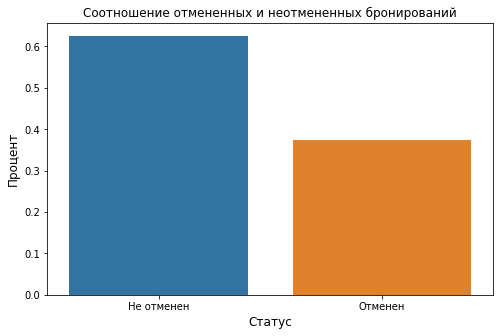

In [91]:
plt.figure(figsize=(8, 5))
sns.barplot(x=data['is_canceled'].unique(), y=data['is_canceled'].value_counts(normalize=True))
plt.title('Соотношение отмененных и неотмененных бронирований')

plt.xticks(ticks=[0, 1], labels=['Не отменен', 'Отменен'])

plt.xlabel('Статус', fontsize = 12)
plt.ylabel('Процент', fontsize = 12)

plt.show()


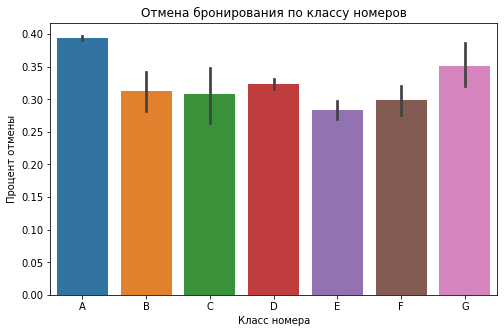

In [92]:
plt.figure(figsize=(8, 5))

sns.barplot(data=data, x='reserved_room_type', y='is_canceled', order=['A','B','C','D','E','F','G'])
plt.title('Отмена бронирования по классу номеров')


plt.xlabel('Класс номера', fontsize = 10)
plt.ylabel('Процент отмены', fontsize = 10)

plt.show()

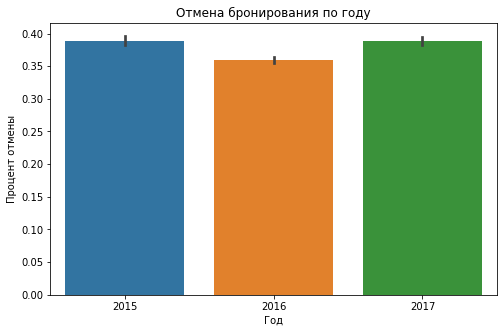

In [93]:
plt.figure(figsize=(8, 5))

sns.barplot(data=data, x='arrival_date_year', y='is_canceled')
plt.title('Отмена бронирования по году')


plt.xlabel('Год', fontsize = 10)
plt.ylabel('Процент отмены', fontsize = 10)

plt.show()

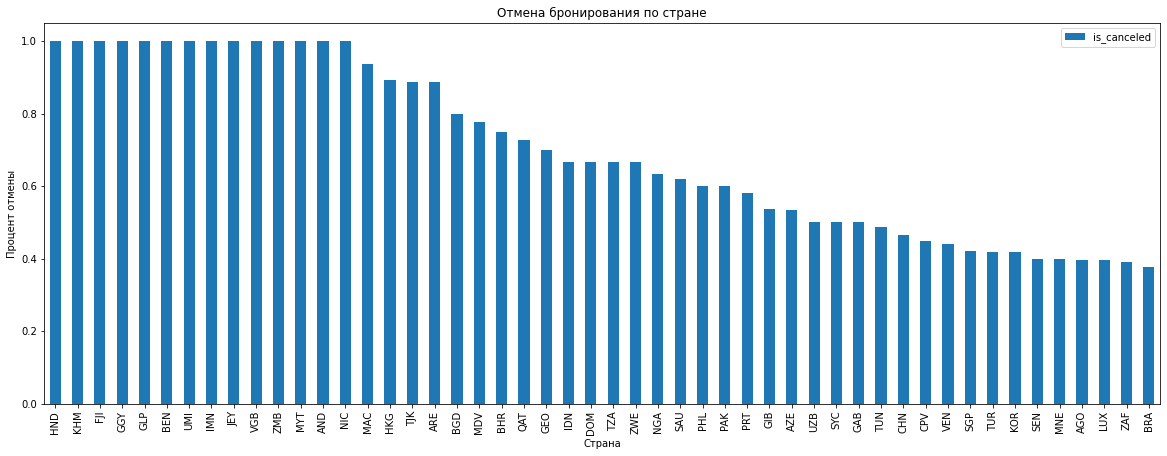

In [94]:
data.pivot_table(index='country', values='is_canceled', aggfunc='mean').sort_values(by='is_canceled', ascending=False)[:50].plot(kind='bar', figsize=(20, 7))
plt.title('Отмена бронирования по стране')

plt.xticks(rotation= 90)
plt.xlabel('Страна', fontsize = 10)
plt.ylabel('Процент отмены', fontsize = 10)

plt.show()

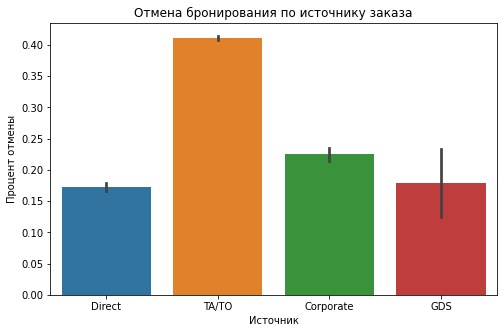

In [95]:
plt.figure(figsize=(8, 5))

sns.barplot(data=data, x='distribution_channel', y='is_canceled')
plt.title('Отмена бронирования по источнику заказа')


plt.xlabel('Источник', fontsize = 10)
plt.ylabel('Процент отмены', fontsize = 10)

plt.show()

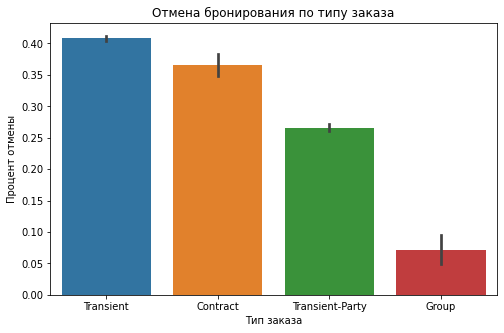

In [96]:
plt.figure(figsize=(8, 5))

sns.barplot(data=data, x='customer_type', y='is_canceled')
plt.title('Отмена бронирования по типу заказа')


plt.xlabel('Тип заказа', fontsize = 10)
plt.ylabel('Процент отмены', fontsize = 10)

plt.show()

34235 отмененных заказов отменяется в день заказа. Это 94.0 % всех отмененных заказов


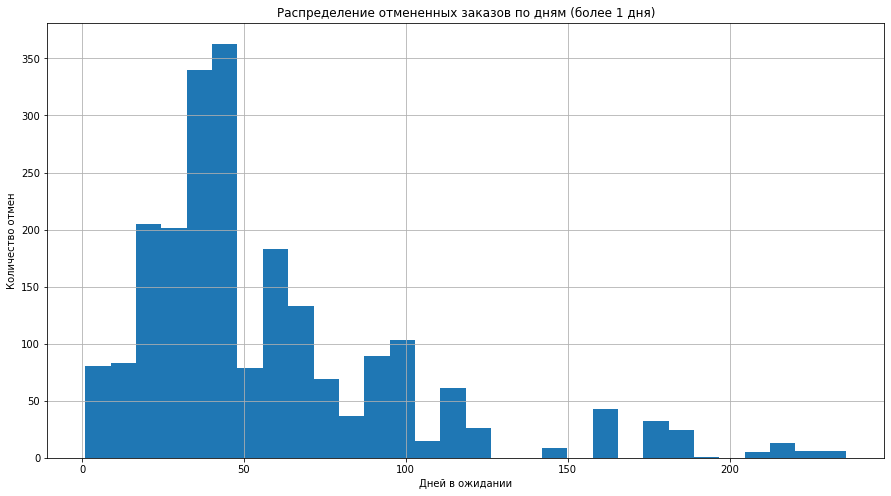

In [97]:
print(len(data.query('is_canceled == 1 & days_in_waiting_list == 0')), 'отмененных заказов отменяется в день заказа. Это', round(len(data.query('is_canceled == 1 & days_in_waiting_list == 0')) / len(data.query('is_canceled == 1')), 2)* 100, '% всех отмененных заказов')
data.query('is_canceled == 1 & days_in_waiting_list > 0').sort_values(by='days_in_waiting_list', ascending=False)['days_in_waiting_list'].hist(bins=30, figsize=(15, 8))
plt.title('Распределение отмененных заказов по дням (более 1 дня)')
plt.xlabel('Дней в ожидании')
plt.ylabel('Количество отмен')
plt.show()

Посмотрим зависимость целевого признака от остальных.

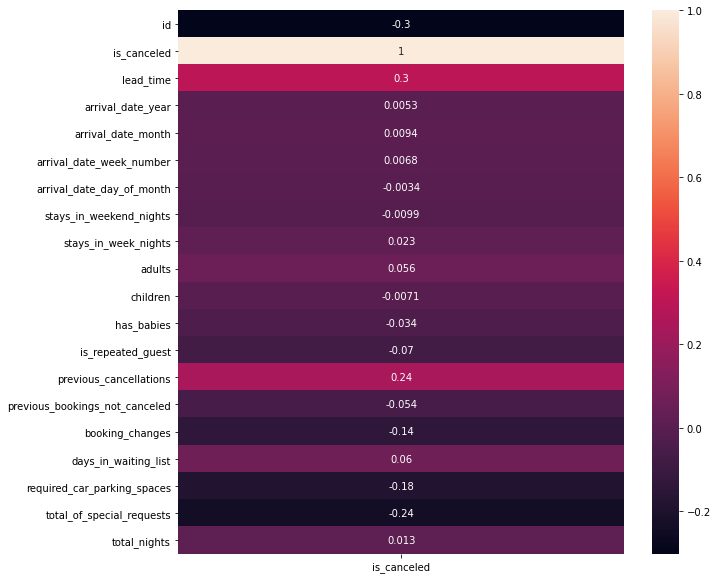

In [98]:
plt.figure(figsize=(10, 10))

sns.heatmap(data.corr()[['is_canceled']], annot = True)
plt.show()

И корреляцию всех признаков

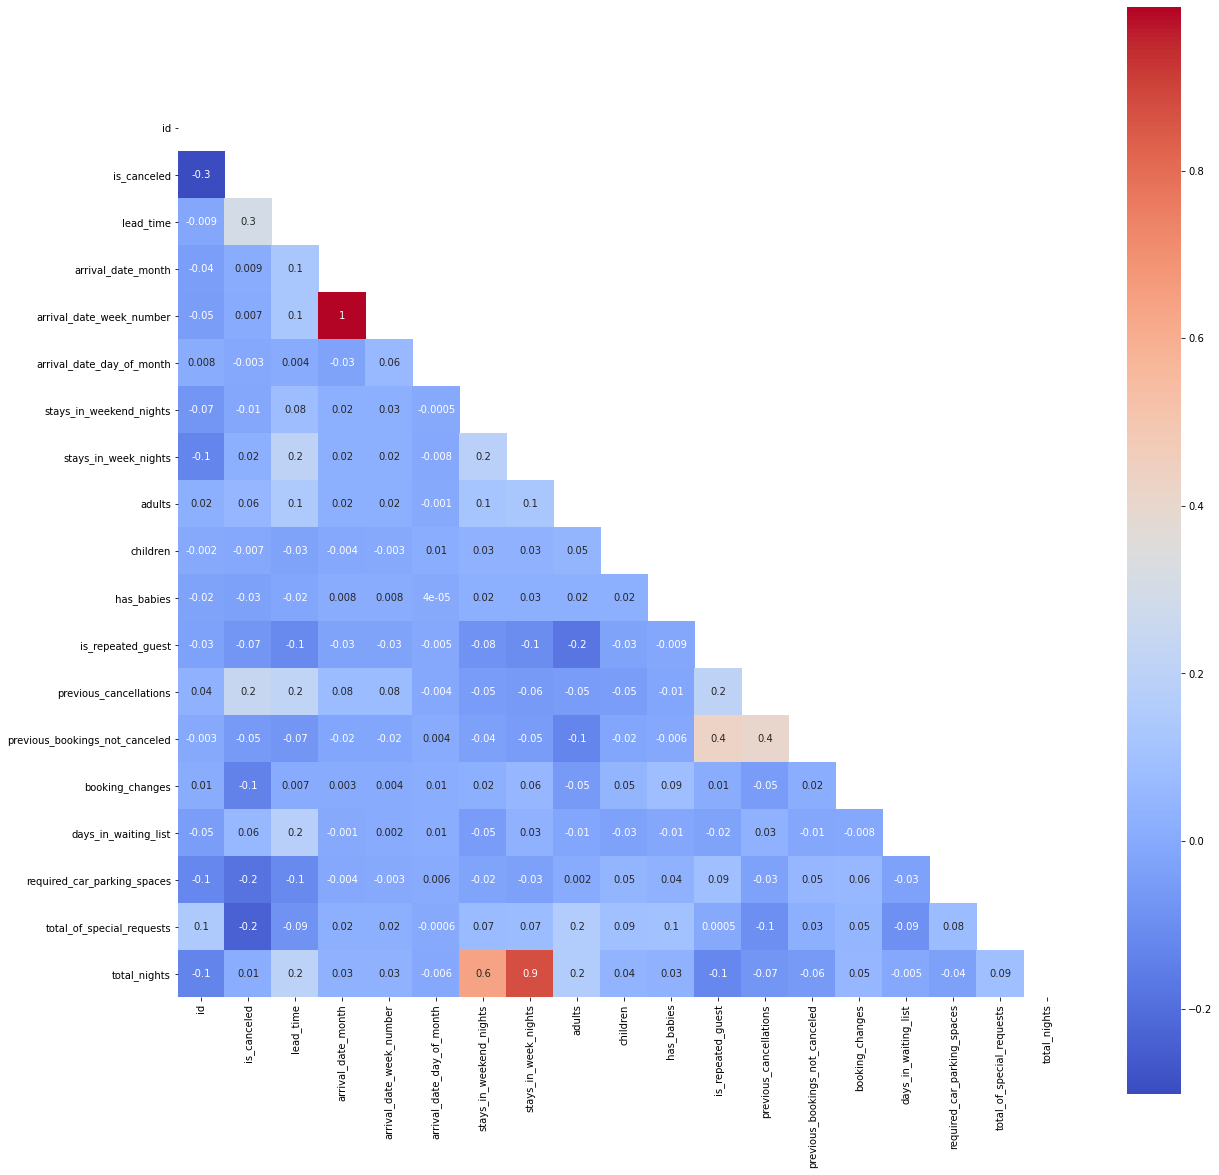

In [99]:
plt.figure(figsize=(20, 20))


sns.heatmap(
    data.drop(['arrival_date_year'], axis=1).corr(), 
    annot=True, 
    fmt='.1g',
    #vmin=-1, vmax=1, center= 0,
    cmap= 'coolwarm', square=True,
    mask=np.triu(data.drop(['arrival_date_year'], axis=1).corr())
)
plt.show()

## Краткий вывод

Данные для поиска аномальных и ошибочных значений объединены. Исключены невозможные и выбивающиеся значения.

Исследованы зависимости отмененных заказов, выявлено отсутствие линейной связи с каким-либо признаком.

Заметим, что:

* процент отмен бронирования ~37.5%;

* по годам процент отмен изменяется несущественно. Разве что за 8 представленных месяцев 2017 г. отмен почти столько же, сколько и за прошлые года целиком. Возможно, это и послужило толчком к введению депозитов;

* чаще других отменяют самые дорогие и самые дешевые номера;

* заказы из некоторых стран отменяются в 100% случаев;

* групповые заказы отменяют реже;

* отменяют заказы почти всегда в день заказа.

# Бизнес-метрика
Рассчитаем прибыль отеля

In [100]:
def profit_table(data, predicted_column='is_canceled'):
    profit_table = data[[predicted_column, 'arrival_date_week_number', 'reserved_room_type', 'stays_in_weekend_nights', 'stays_in_week_nights']]

    profit_table['cost'] = 0
    profit_table.loc[profit_table['reserved_room_type'] == "A", 'cost'] = 1000
    profit_table.loc[profit_table['reserved_room_type'] == "B", 'cost'] = 800
    profit_table.loc[profit_table['reserved_room_type'] == "C", 'cost'] = 600
    profit_table.loc[profit_table['reserved_room_type'] == "D", 'cost'] = 550
    profit_table.loc[profit_table['reserved_room_type'] == "E", 'cost'] = 500
    profit_table.loc[profit_table['reserved_room_type'] == "F", 'cost'] = 450
    profit_table.loc[profit_table['reserved_room_type'] == "G", 'cost'] = 350


    profit_table['cleaning'] = 0
    profit_table.loc[profit_table['reserved_room_type'] == "A", 'cleaning'] = 400
    profit_table.loc[profit_table['reserved_room_type'] == "B", 'cleaning'] = 350
    profit_table.loc[profit_table['reserved_room_type'] == "C", 'cleaning'] = 350
    profit_table.loc[profit_table['reserved_room_type'] == "D", 'cleaning'] = 150
    profit_table.loc[profit_table['reserved_room_type'] == "E", 'cleaning'] = 150
    profit_table.loc[profit_table['reserved_room_type'] == "F", 'cleaning'] = 150
    profit_table.loc[profit_table['reserved_room_type'] == "G", 'cleaning'] = 150

    profit_table['season_coef'] = 1
    profit_table.loc[profit_table['arrival_date_week_number'].isin(list(range(13, 48))), 'season_coef'] = 1.2
    profit_table.loc[profit_table['arrival_date_week_number'].isin(list(range(22, 36))), 'season_coef'] = 1.4

    # Общая прибыль при заселении. Уборку считаем расходами отеля, а не обязательной оплатой клиента, т.е. стоимость уборки включена в стоимость номера
    profit_table.loc[profit_table[predicted_column] == 0, 'profit'] = (
        (profit_table['stays_in_weekend_nights'] + profit_table['stays_in_week_nights']) * profit_table['cost'] * profit_table['season_coef'] -
        profit_table['cleaning'] * (((profit_table['stays_in_weekend_nights'] + profit_table['stays_in_week_nights']) // 2) + 1)
    )
    # Убыток при отмене бронирования равен стоимости одной уборки и одной ночи
    profit_table.loc[profit_table[predicted_column] == 1, 'profit'] = - profit_table['cost'] * profit_table['season_coef'] - profit_table['cleaning']

    total_profit = profit_table['profit'].sum()

    return profit_table, total_profit

profit_table_full, total_profit_full = profit_table(data)

In [101]:
profit_table_full.sample(15)

,is_canceled,arrival_date_week_number,reserved_room_type,stays_in_weekend_nights,stays_in_week_nights,cost,cleaning,season_coef,profit
10156,0,7,A,1,1,1000,400,1.0,1200.0
82807,1,33,A,1,3,1000,400,1.4,-1800.0
746,0,35,A,1,0,1000,400,1.4,1000.0
76367,1,15,A,2,0,1000,400,1.2,-1600.0
60830,0,41,A,1,2,1000,400,1.2,2800.0
85736,0,8,A,2,0,1000,400,1.0,1200.0
43090,0,47,A,1,0,1000,400,1.2,800.0
36940,1,27,A,0,2,1000,400,1.4,-1800.0
4521,0,29,G,1,4,350,150,1.4,2000.0
55502,0,30,A,0,1,1000,400,1.4,1000.0


In [102]:
# Прибыль отеля за каждый год

full_profit = 0
for i in data['arrival_date_year'].unique():
    year_index = data.loc[data["arrival_date_year"] == i, 'id'].index
    full_profit += profit_table_full.query('index.isin(@year_index)')['profit'].sum()
    print(f'Прибыль за {i}-й год: {profit_table_full.query("index.isin(@year_index)")["profit"].sum()}')

print(f'Суммарная прибыль:      {full_profit}')

Прибыль за 2015-й год: 17328460.0
Прибыль за 2016-й год: 47668960.0
Прибыль за 2017-й год: 31630050.0
Суммарная прибыль:      96627470.0


# Разработка модели ML

Обучим разные модели и оценим их качество кросс-валидацией. Проверим лучшую модедь на тестовой выборке.

In [103]:
def roc_graph(target_valid, probabilities_one_valid):
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange") 
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.02])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая") 
    plt.grid()
    plt.show()

Проверим стобцы в общем датасете и определим нужные

In [104]:
data.columns

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', ' has_babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'],
      dtype='object')

Для обучения не нужны столбцы:
* `id`
* с годом (он не дает важной информации);
* месяцем (есть номер недели, его достаточно); 
* по которым считали доходность (`cost`, `cleaning`, `season_coef`);
* общего числа ночей (есть ночи в будни и выходные).

Столбец с годом будем удалять последним, поскольку он является макрером обучающей и тренировочной выборки

In [105]:
# Удалим столбцы
data = data.drop(['id', 'arrival_date_month', 'total_nights'], axis=1)


In [106]:
# и поделим выборки обратно, удалив и столбец с годом
hotel_train = data.query('arrival_date_year != 2017').drop(['arrival_date_year'], axis=1).reset_index(drop=True)
hotel_test = data.query('arrival_date_year == 2017').drop(['arrival_date_year'], axis=1).reset_index(drop=True)

print('Размер обучающей выборки', hotel_train.shape)
print('Размер тестовой выборки', hotel_test.shape)

Размер обучающей выборки (64920, 21)
Размер тестовой выборки (32343, 21)


In [107]:
# и выделим целевой признак
features_train = hotel_train.drop(['is_canceled'], axis=1)
target_train = hotel_train['is_canceled']

features_test = hotel_test.drop(['is_canceled'], axis=1)
target_test = hotel_test['is_canceled']


In [108]:
# Закодируем категориальные столбцы

categories = ['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

ohe.fit(features_train[categories])
encoded_data = pd.DataFrame(ohe.transform(features_train[categories]), columns=ohe.get_feature_names_out(features_train[categories].columns))
features_train_ohe = features_train.merge(encoded_data, on=features_train.index).drop(categories, axis=1).drop(['key_0'], axis=1)

#  key_0 - это столбец, образующийся из-за того, что соединяю по иднексам? 

ohe.fit(features_test[categories])
encoded_data = pd.DataFrame(ohe.transform(features_test[categories]), columns=ohe.get_feature_names_out(features_test[categories].columns))
features_test_ohe = features_test.merge(encoded_data, on=features_test.index).drop(categories, axis=1).drop(['key_0'], axis=1)


In [109]:
categorical_columns = ['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type']
numeric_columns = features_train.select_dtypes(include=['int','float']).columns
    
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
    
encoder.fit(features_train[categorical_columns])
    
features_train_encoded = pd.DataFrame(
    encoder.transform(features_train[categorical_columns]).toarray(),
    columns=encoder.get_feature_names_out(categorical_columns),
    index=features_train.index
)
features_train_final_encoded = pd.concat((features_train[numeric_columns], features_train_encoded), axis=1)

features_test_encoded = pd.DataFrame(
    encoder.transform(features_test[categorical_columns]).toarray(),
    columns=encoder.get_feature_names_out(categorical_columns),
    index=features_test.index
)
features_test_final_encoded = pd.concat((features_test[numeric_columns], features_test_encoded), axis=1)


print('Train:', features_train_final_encoded.shape)

print('Test:', features_test_final_encoded.shape)

Train: (64920, 184)
Test: (32343, 184)


c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [110]:
features_train_ohe = features_train_final_encoded

features_test_ohe = features_test_final_encoded

In [111]:
print('Train:', features_train_ohe.shape)

print('Test:', features_test_ohe.shape)

Train: (64920, 184)
Test: (32343, 184)


In [112]:
# Выровняем столбцы

for i in features_train_ohe.columns:
    if i not in features_test_ohe.columns:
        features_test_ohe[i] = 0
        

for i in features_test_ohe.columns:
    if i not in features_train_ohe.columns:
        features_train_ohe[i] = 0

features_test_ohe = features_test_ohe[list(features_train_ohe.columns)]

for i in range(len(features_test_ohe.columns)):
    if features_test_ohe.columns[i] != features_train_ohe.columns[i]:
        print('Не соответстует', features_test_ohe.columns[i])
print('Train:', features_train_ohe.shape)

print('Test:', features_test_ohe.shape)


Train: (64920, 184)
Test: (32343, 184)


In [113]:
# Масштабируем
cols_for_scale = features_train.select_dtypes(include=['int','float']).columns

scaler = StandardScaler()
scaler.fit(features_train_ohe[cols_for_scale])
features_train_ohe[cols_for_scale] = scaler.transform(features_train_ohe[cols_for_scale])

scaler.fit(features_test_ohe[cols_for_scale])
features_test_ohe[cols_for_scale] = scaler.transform(features_test_ohe[cols_for_scale])


features_train_ohe

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GIB,country_GLP,country_GNB,country_GRC,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KNA,country_KOR,country_KWT,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MUS,country_MWI,country_MYS,country_NAM,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SEN,country_SGP,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.927809,-0.323308,-1.698201,-0.966205,-0.903642,-1.781191,-0.219585,-0.083265,-0.165462,-0.287081,-0.079341,-0.327002,-0.182827,-0.244507,-0.681263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.854959,-0.323308,-1.698201,-0.966205,-0.165260,0.336742,-0.219585,-0.083265,-0.165462,-0.287081,-0.079341,-0.327002,-0.182827,-0.244507,0.647851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Оценим предварительно качество моделей с помощью кросс-валидации

In [114]:
model_rf = RandomForestClassifier(random_state=RS)
score_rf = cross_val_score(model_rf, features_train_ohe, target_train, cv=10)
print('RandomForest cros-val score:', sum(score_rf)/len(score_rf))

model_lr = LogisticRegression(random_state=RS, solver='liblinear')
score_lr = cross_val_score(model_lr, features_train_ohe, target_train, cv=10)
print('LogisticRegression cros-val score:', sum(score_lr)/len(score_lr))

model_dt = DecisionTreeClassifier(random_state=RS)
score_dt = cross_val_score(model_dt, features_train_ohe, target_train, cv=10)
print('DecisionTree cros-val score:', len(score_dt)/len(score_dt))

RandomForest cros-val score: 0.6943930991990143
LogisticRegression cros-val score: 0.7723813924830562
DecisionTree cros-val score: 1.0


Создадим константную модель


F1-score: 0.0
ROC_auc: 0.5


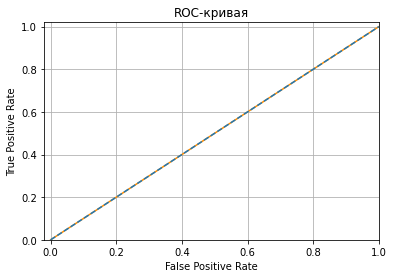

In [115]:
dummy_model = DummyClassifier(random_state=RS)
dummy_model.fit(features_train_ohe, target_train)
prediction_dummy = dummy_model.predict(features_test_ohe)
print("F1-score:", f1_score(target_test, prediction_dummy))
print("ROC_auc:", roc_auc_score(target_test, prediction_dummy))
dummy_proba = dummy_model.predict_proba(features_test_ohe)[:, 1]
roc_graph(target_test, dummy_proba)

Поработаем с моделями.

Определимся с метриками.

TP - число отмененных броней, которые модель предсказала отмененными. В таком случае с клиента будет удержан депозит, и отель не останется внакладе, так как депозит перекроет стоимось уборки.

TN - число неотмененных броней, которые модель предсказала неотмененными. В таком случае клиент оплатит проживание, расходов не будет, а прибыль не изменится.

FP - число неотмененных броней, которые модель предсказала отмененными. В таком случае депозит идет в счет оплаты номера, и снова все хорошо - прибыль также не меняется.

FN - число отмененных броней, которые модель предсказала неотмененными. В этом случае отель несет убытки из-за расходов на уборку.

Следовательно, как метрики можно использовать полноту (Recall) и F1-score.


<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: окей, принимается :)</div>

### Выберем модель по лучшим метрикам

1. Случайный лес.

In [116]:
# RandomForest

rf_parameters = {'max_depth': [2, 4, 16, 32],
              'n_estimators': [10, 30, 50],
              'max_features':[1, 2, 3],
              'criterion':['gini','entropy'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split':[2, 4, 8]
              }

model = RandomForestClassifier(random_state=RS, class_weight='balanced')
rf_random = GridSearchCV(model, rf_parameters, scoring='f1', cv=10, verbose=1)
model_random_rf = rf_random.fit(features_train_ohe, target_train)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


In [117]:
rf_best = RandomForestClassifier(random_state=RS, class_weight='balanced')
rf_best.set_params(**model_random_rf.best_params_)
rf_best.fit(features_train_ohe, target_train)
cross_val_mean = sum(cross_val_score(rf_best, features_train_ohe, target_train, cv=10))/len(cross_val_score(rf_best, features_train_ohe, target_train, cv=10))

In [118]:
print('Случайный поиск гиперпараметров')
print('Лучшие гиперпараметры:', model_random_rf.best_params_)
print(f'Лучший F1 на обучающей выборке: {rf_best.score(features_train_ohe, target_train)}')
print(f'Cross-Val score: {cross_val_mean}')

result_cols = ['f1', 'cross_val_mean']
rf_result = [rf_best.score(features_train_ohe, target_train), cross_val_mean]


Случайный поиск гиперпараметров
Лучшие гиперпараметры: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 50}
Лучший F1 на обучающей выборке: 0.7644947627849661
Cross-Val score: 0.7403111521873075


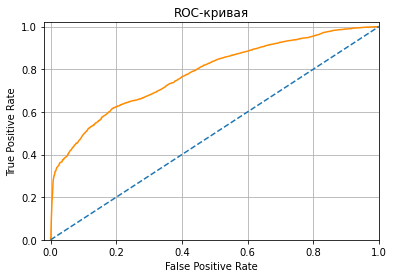

In [119]:

predict_proba_rf = rf_best.predict_proba(features_test_ohe)[:, 1]
roc_graph(target_test, predict_proba_rf)

In [120]:
predictions_test = rf_best.predict(features_test_ohe)

con_matrix_rf = pd.DataFrame(confusion_matrix(target_test, predictions_test), columns=['0', "1"])
con_matrix_rf

,0,1
0,16110,3673
1,4866,7694


2. Дерево решений

In [121]:
# DecisionTree

dt_parameters = {'max_depth': [2, 4, 16, 32],
              'max_features':[1, 2, 3],
              'criterion':['gini','entropy'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split':[2, 4, 8]
              }

model = DecisionTreeClassifier(random_state=RS, class_weight='balanced')
dt_random = GridSearchCV(model, dt_parameters, scoring='f1', cv=10, verbose=1)
model_random_dt = dt_random.fit(features_train_ohe, target_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


In [122]:
dt_best = DecisionTreeClassifier(random_state=RS, class_weight='balanced')
dt_best.set_params(**model_random_dt.best_params_)
dt_best.fit(features_train_ohe, target_train)
cross_val_mean = sum(cross_val_score(dt_best, features_train_ohe, target_train, cv=10))/len(cross_val_score(dt_best, features_train_ohe, target_train, cv=10))

In [123]:
print('Случайный поиск гиперпараметров')
print('Лучшие гиперпараметры:', model_random_dt.best_params_)
print(f'Лучший F1 на обучающей выборке: {dt_best.score(features_train_ohe, target_train)}')
print(f'Cross-Val score: {cross_val_mean}')

dt_result = [dt_best.score(features_train_ohe, target_train), cross_val_mean]


Случайный поиск гиперпараметров
Лучшие гиперпараметры: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 2}
Лучший F1 на обучающей выборке: 0.7032655576093654
Cross-Val score: 0.6961028958718423


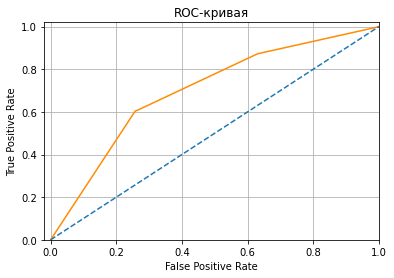

In [124]:
predict_proba_dt = model_random_dt.predict_proba(features_test_ohe)[:, 1]
roc_graph(target_test, predict_proba_dt)

3. Логистическая регрессия

In [125]:
# Logistic Regression

lr_params = {
    'penalty':['l1','l2'],
    'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
    }


model = LogisticRegression(random_state=RS, solver='liblinear')

lr_random = GridSearchCV(model, lr_params, cv=10, scoring='f1', verbose=1)

lr_model_random = lr_random.fit(features_train_ohe, target_train)


Fitting 10 folds for each of 14 candidates, totalling 140 fits


In [126]:
lr_best = LogisticRegression(random_state=RS, solver='liblinear')
lr_best.set_params(**lr_model_random.best_params_)
lr_best.fit(features_train_ohe, target_train)
cross_val_mean = sum(cross_val_score(lr_best, features_train_ohe, target_train, cv=10))/len(cross_val_score(lr_best, features_train_ohe, target_train, cv=10))

In [127]:
print('Случайный поиск гиперпараметров')
print('Лучшие гиперпараметры:', lr_model_random.best_params_)
print(f'Лучший F1 на обучающей выборке: {lr_best.score(features_train_ohe, target_train)}')
print(f'Cross-Val score: {cross_val_mean}')

lr_result = [lr_best.score(features_train_ohe, target_train), cross_val_mean]


Случайный поиск гиперпараметров
Лучшие гиперпараметры: {'C': 1, 'penalty': 'l2'}
Лучший F1 на обучающей выборке: 0.8075477510782502
Cross-Val score: 0.7723813924830562


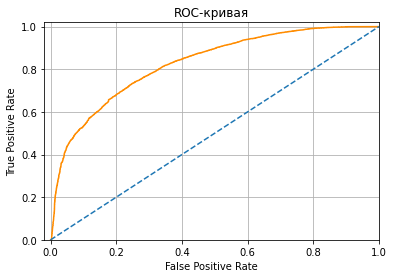

In [128]:

predict_proba_lr = lr_best.predict_proba(features_test_ohe)[:, 1]
roc_graph(target_test, predict_proba_lr)

In [129]:
full_result = pd. DataFrame([rf_result, dt_result, lr_result], index=['RandomForest', 'DecisionTree', 'LogisticRegression'], columns=result_cols)
full_result

,f1,cross_val_mean
RandomForest,0.764495,0.740311
DecisionTree,0.703266,0.696103
LogisticRegression,0.807548,0.772381


Таким образом, лучшей моделью является RandomForest.

С его помощью оценим прибыль отеля за год.

In [130]:
predictions = rf_best.predict(features_test_ohe)

# Сделаем копию
features_test_predictions = hotel_test.copy()

# Добавим стольбец с предсказаниями
features_test_predictions['predicted_canceling'] = predictions

In [131]:

profit_table_predicted, total_profit_predicted = profit_table(features_test_predictions, 'predicted_canceling')

profit_table_test, total_profit_test = profit_table(features_test_predictions, 'is_canceled')

profit_table_predicted = pd.concat([profit_table_predicted, features_test_predictions['is_canceled']], axis=1)

In [132]:
def profit_with_deposit(row):
    if row['is_canceled'] == 1 and row['predicted_canceling'] == 1:
        return row['profit'] * 0.2
    return row['profit']

profit_table_predicted['profit_with_deposit'] = profit_table_predicted.apply(profit_with_deposit, axis=1)

# итоговая прибыль от модели
print(profit_table_predicted['profit_with_deposit'].sum() - profit_table_predicted['profit'].sum() - 400_000)

profit_table_predicted

8630440.0


,predicted_canceling,arrival_date_week_number,reserved_room_type,stays_in_weekend_nights,stays_in_week_nights,cost,cleaning,season_coef,profit,is_canceled,profit_with_deposit
0,1,1,A,1,0,1000,400,1.0,-1400.0,1,-280.0
1,0,1,A,2,2,1000,400,1.0,2800.0,1,2800.0
2,0,1,A,2,2,1000,400,1.0,2800.0,1,2800.0
3,1,1,A,2,2,1000,400,1.0,-1400.0,1,-280.0
4,1,1,A,2,5,1000,400,1.0,-1400.0,1,-280.0
...,...,...,...,...,...,...,...,...,...,...,...
32338,1,35,A,2,4,1000,400,1.4,-1800.0,0,-1800.0
32339,0,35,A,2,5,1000,400,1.4,8200.0,0,8200.0
32340,0,35,A,2,5,1000,400,1.4,8200.0,0,8200.0
32341,0,35,D,2,5,550,150,1.4,4790.0,0,4790.0


In [133]:


def expriment(profit_table_predicted=profit_table_predicted, iteration=500):
    experimental_profit = 0

    for _ in range(iteration):
        profit_table_predicted['is_still_client'] = 1 
        profit_table_predicted.loc[(profit_table_predicted['predicted_canceling'] == 1) & (profit_table_predicted['is_canceled'] == 1), 'is_still_client'] = random.randint(0, 1) # 
        profit_table_predicted['profit_experiment'] = profit_table_predicted['profit'] * profit_table_predicted['is_still_client']
        experimental_profit += profit_table_predicted['profit_experiment'].sum()
    return experimental_profit / iteration


experimental_profit = expriment()
experimental_profit

profit_table_predicted.loc[profit_table_predicted['is_still_client'] == 0]


,predicted_canceling,arrival_date_week_number,reserved_room_type,stays_in_weekend_nights,stays_in_week_nights,cost,cleaning,season_coef,profit,is_canceled,profit_with_deposit,is_still_client,profit_experiment


In [134]:
print('Фактическая прибыль за 2017 г.:  ', total_profit_test )
print('Предсказанная прибыль за 2017 г.:', total_profit_predicted )
print('Предсказанная прибыль за 2017 г. с учетом отказов:', experimental_profit)
print('Повышение прибыли после внедрения депозитов (без учета отказов):', total_profit_predicted - total_profit_test)
print()
print('Повышение прибыли после внедрения депозитов (с учетом отказов): ', round(experimental_profit - total_profit_test, 1))


Фактическая прибыль за 2017 г.:   31630050.0
Предсказанная прибыль за 2017 г.: 36237440.0
Предсказанная прибыль за 2017 г. с учетом отказов: 41994345.5
Повышение прибыли после внедрения депозитов (без учета отказов): 4607390.0

Повышение прибыли после внедрения депозитов (с учетом отказов):  10364295.5


## Краткий вывод

Данные были преобразованы в вид, подходящий для машинного обучения.

Обучены три модели - дерево решений, случайный лес и логистическая регрессия. Лучше других показала себя модель случайного леса.

С ее помощью была оценено увеличение прибыли после внедрения депозитов. Результат - увеличение прибыли на 484140.

Поскольку затраты на разработку модели составляют 400000, то внедрение системы депозитов и модели, предсказывающей отказ от бронирования, является разумным решением.

# Признаки «ненадёжного» клиента

In [135]:
canceling = pd.concat([train, test]).reset_index(drop=True)


Почистим ненужные столбцы.

In [136]:
canceling.columns

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights'],
      dtype='object')

Не понадобятся:

* `id` — идентификатор, не несет нужной информации;

* `arrival_date_month` — практически дублируется номером недели;

* `total_nights` — тоже дублер количества ночей в будни и выходные.

In [137]:
canceling = canceling.drop(['id', 'arrival_date_month', 'total_nights'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97641 entries, 0 to 97640
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     97641 non-null  int64  
 1   lead_time                       97641 non-null  float64
 2   arrival_date_year               97641 non-null  int64  
 3   arrival_date_week_number        97641 non-null  int64  
 4   arrival_date_day_of_month       97641 non-null  int64  
 5   stays_in_weekend_nights         97641 non-null  int64  
 6   stays_in_week_nights            97641 non-null  int64  
 7   adults                          97641 non-null  float64
 8   children                        97641 non-null  float64
 9   babies                          97641 non-null  float64
 10  meal                            97641 non-null  object 
 11  country                         97641 non-null  object 
 12  distribution_channel            

None

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
count,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000
mean,0.375201,96.752839,2016.144243,26.846581,15.784455,0.839361,2.263066,1.843887,0.077836,0.006667,0.028554,0.089972,0.128860,0.201729,2.314642,0.053195,0.560902
std,0.484177,93.045823,0.706299,13.772847,8.754660,0.853682,1.362798,0.483393,0.337358,0.091790,0.166549,0.797737,1.530961,0.609830,15.224212,0.228000,0.783654
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,68.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,152.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,374.000000,2017.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,72.000000,18.000000,259.000000,8.000000,5.000000


Дубликатов обнаружено:  29094



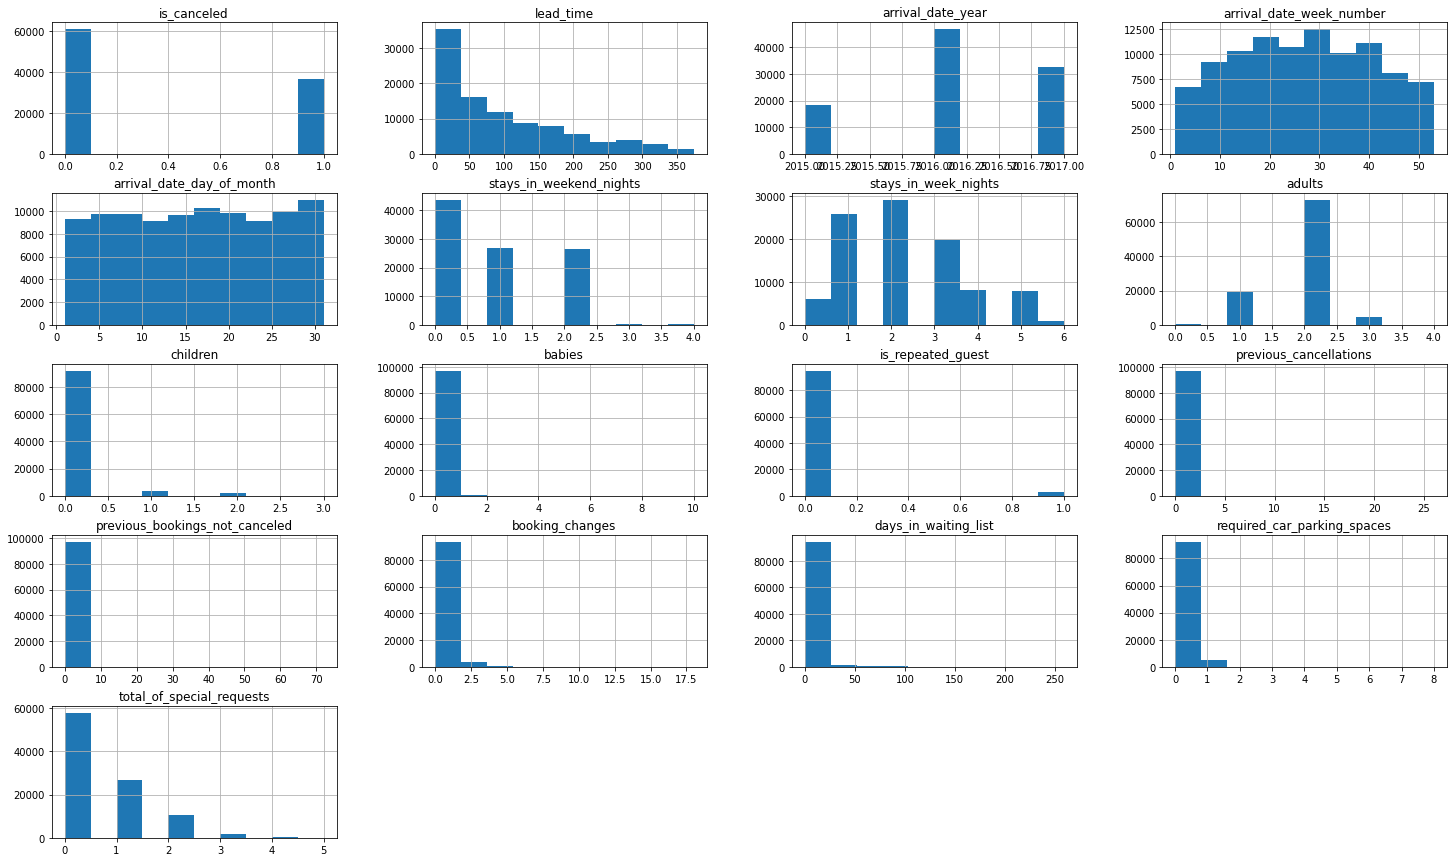


Размер датасета: (97641, 22)

Пропуски
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64


,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
64205,0,0.0,2016,50,7,0,1,3.0,0.0,0.0,BB,ITA,TA/TO,0,0,0,A,0,0,Transient,0,1
52666,0,0.0,2016,24,7,0,1,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1
54578,0,4.0,2016,28,6,0,1,2.0,1.0,0.0,SC,FRA,TA/TO,0,0,0,A,0,0,Transient,0,1
89638,0,133.0,2017,16,19,0,4,2.0,0.0,0.0,BB,ISL,TA/TO,0,0,0,A,2,0,Transient-Party,0,0
29084,1,188.0,2016,25,15,0,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,39,Transient,0,0
79783,1,129.0,2017,22,2,1,2,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0
90798,0,208.0,2017,18,6,2,2,2.0,0.0,0.0,BB,FRA,TA/TO,0,0,0,A,0,0,Transient,0,1
60926,0,222.0,2016,42,12,0,4,2.0,0.0,0.0,BB,ROU,TA/TO,0,0,0,A,0,0,Transient,0,1
63971,0,80.0,2016,49,2,0,2,2.0,0.0,0.0,SC,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1
52842,0,118.0,2016,24,6,1,3,1.0,0.0,0.0,BB,ESP,Corporate,0,0,0,A,1,0,Transient-Party,0,0


In [138]:
first_look(canceling)

Из гистограмм можно сделать вывод, что чаще всего отменяют заказ:

* в тот же день, что он и был сделан;

* в теплое время года;

* на будние дни;

* взрослые без детей любого возраста;

* бронирующие в первый раз;

* без запросов на парковку и специальных запросов.

Посмотрим, как распределяет вес признаков модель.

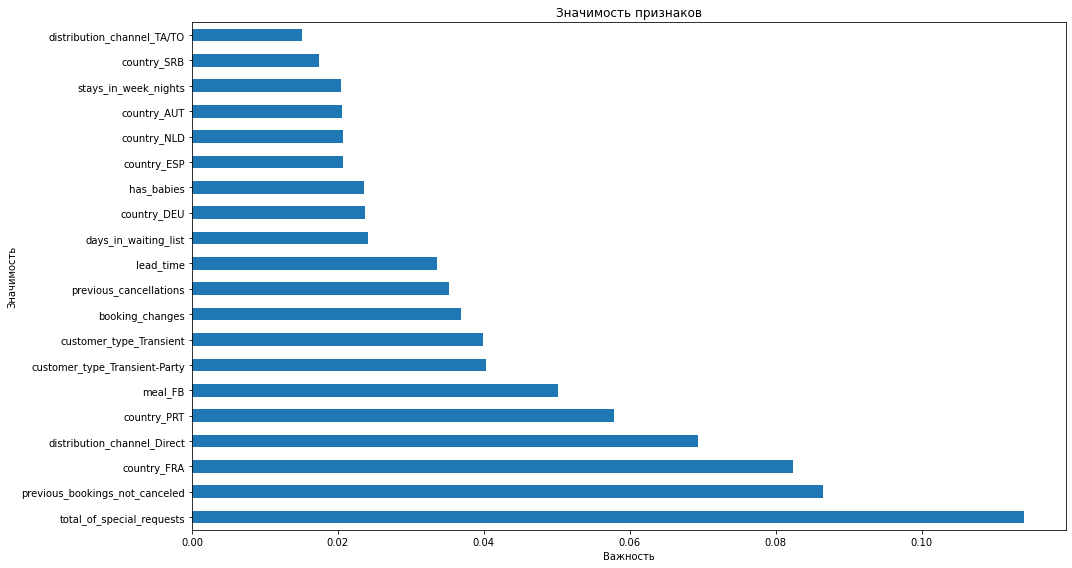

In [139]:
pd.Series(rf_best.feature_importances_, features_train_ohe.columns).nlargest(20).plot(kind='barh', figsize=(15, 8))
plt.title('Значимость признаков')
plt.xlabel('Важность')
plt.ylabel('Значимость')
plt.tight_layout()
plt.show()

Исключив кодированные признаки, можно отметить, что:

* максимальная значимость у времени между бронированием и заездом: чем дольше ждут, тем чаще передумывают, видимо;

* спецзапросы уменьшают вероятность отмены бронирования: думается, это можно назвать конкурентным преимуществом - в отеле есть то, чего нет в других, поэтому реже снимают бронь;

* по тому же принципу, вероятно, работает и изменение параметров заказа.



Далее визуализируем зависимость отмены от категориальных признаков.

In [140]:
def categories(column):
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.subplot()
    fig.suptitle(f'Зависимость отмены бронирования от категории {column}', fontweight="bold")
    sns.barplot(data=canceling, x=column, y='is_canceled')
    plt.title('Фактические отмены')
    plt.xlabel('Категории')
    plt.xticks(rotation=90)
    plt.ylabel('Зависимость целевого признака')
    plt.show()

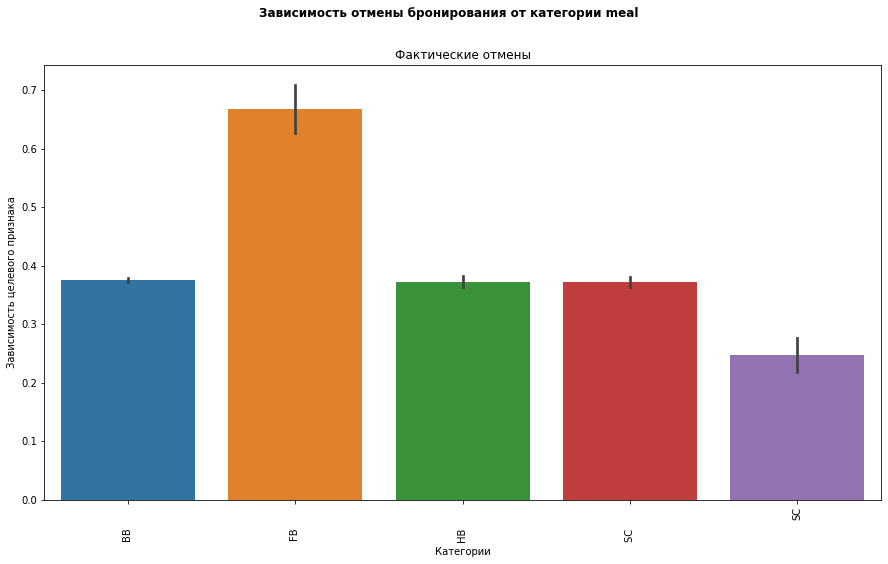

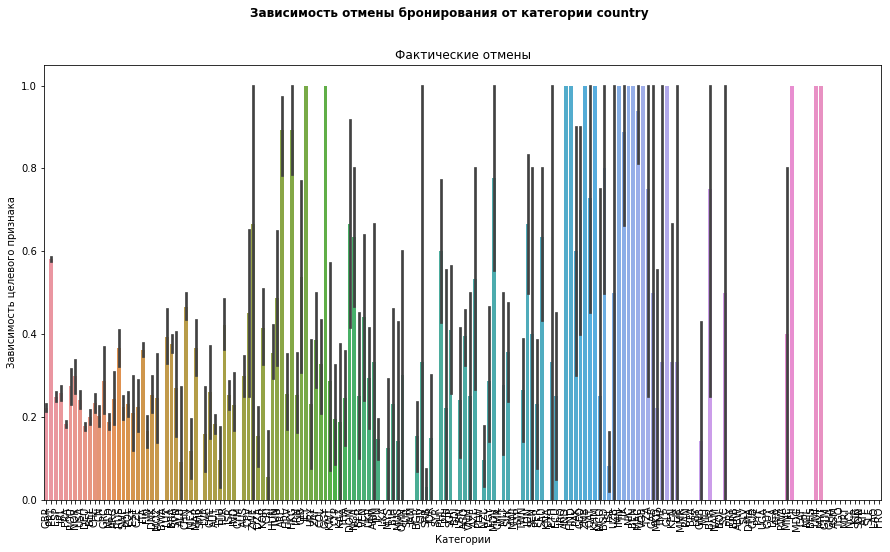

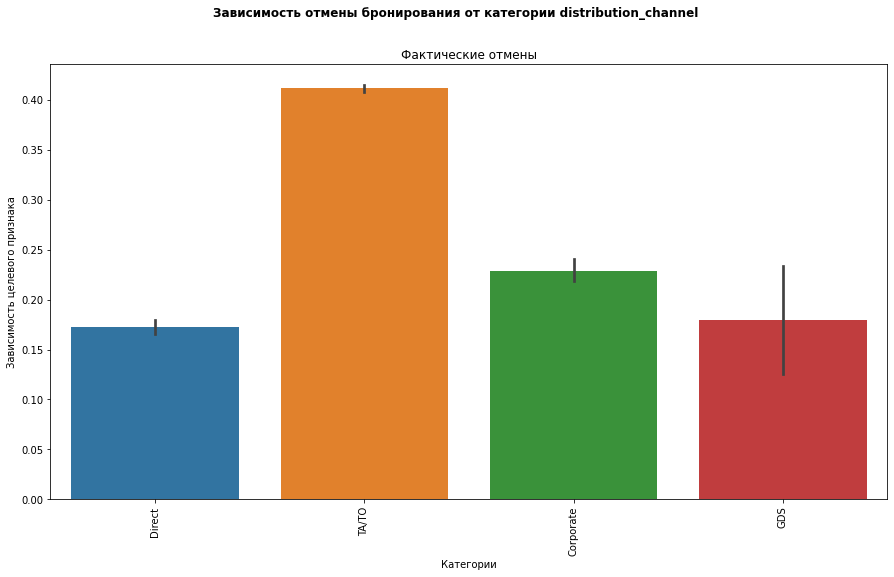

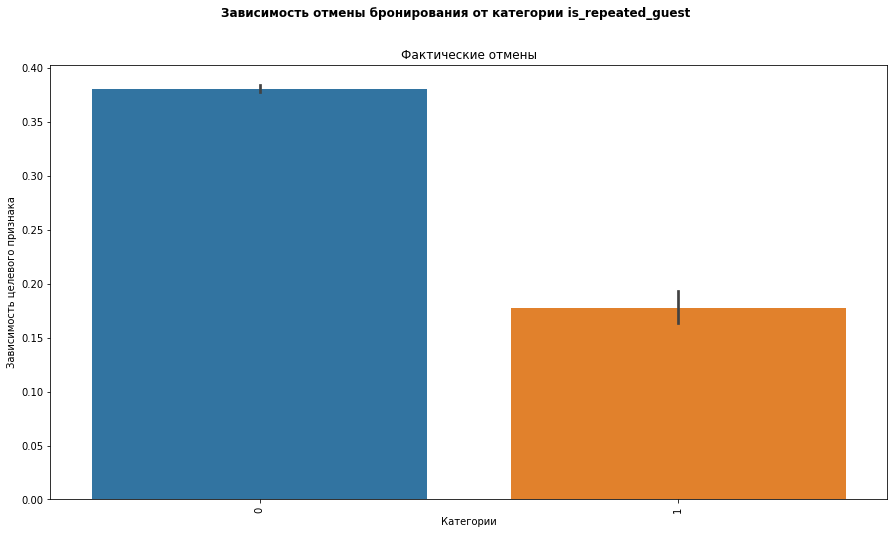

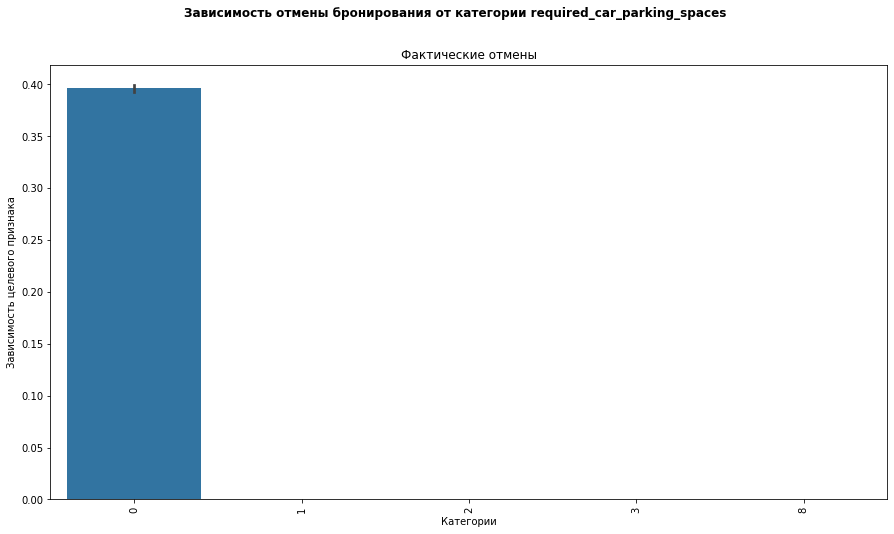

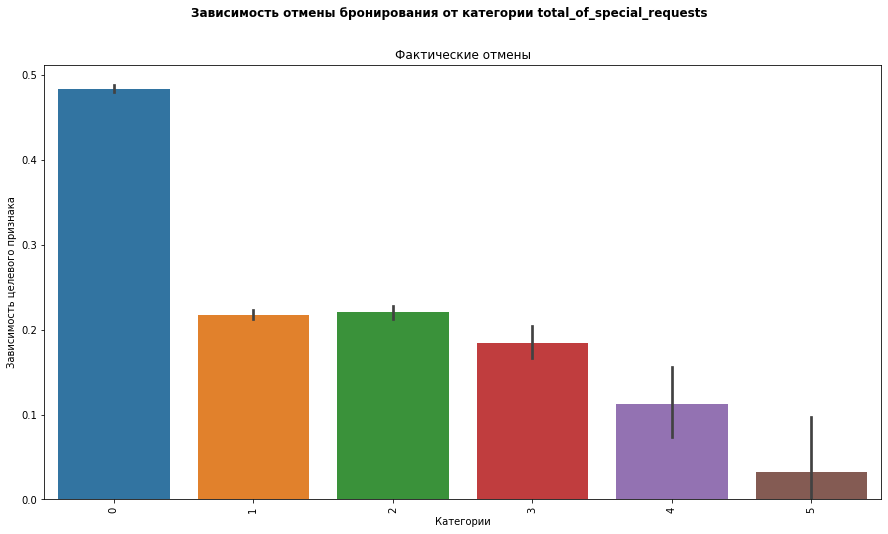

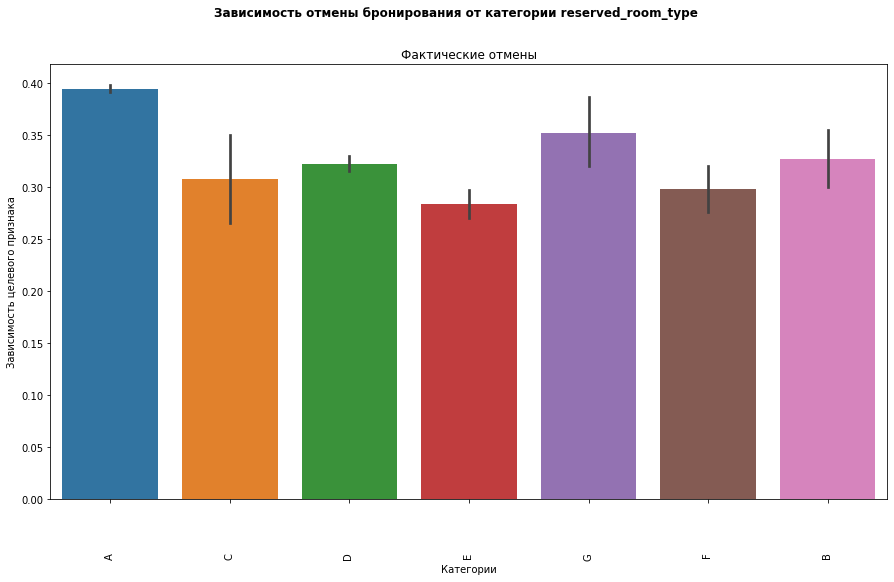

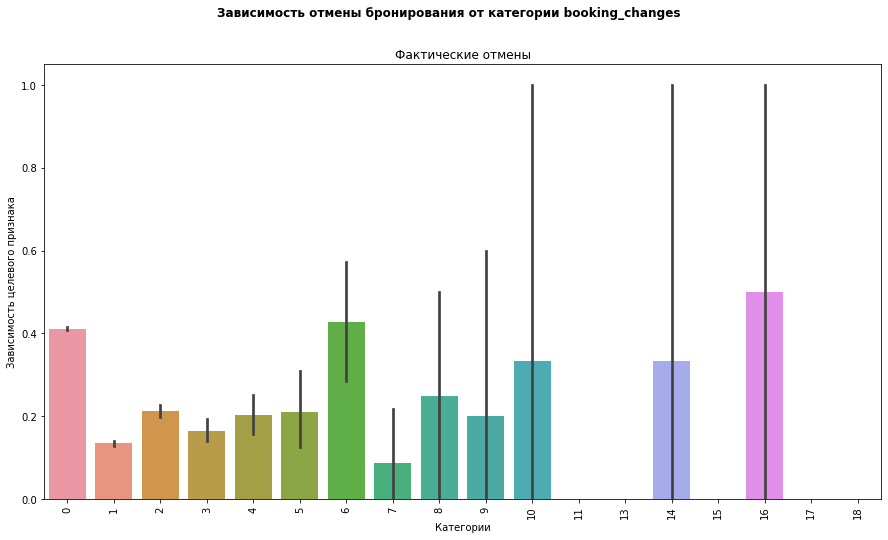

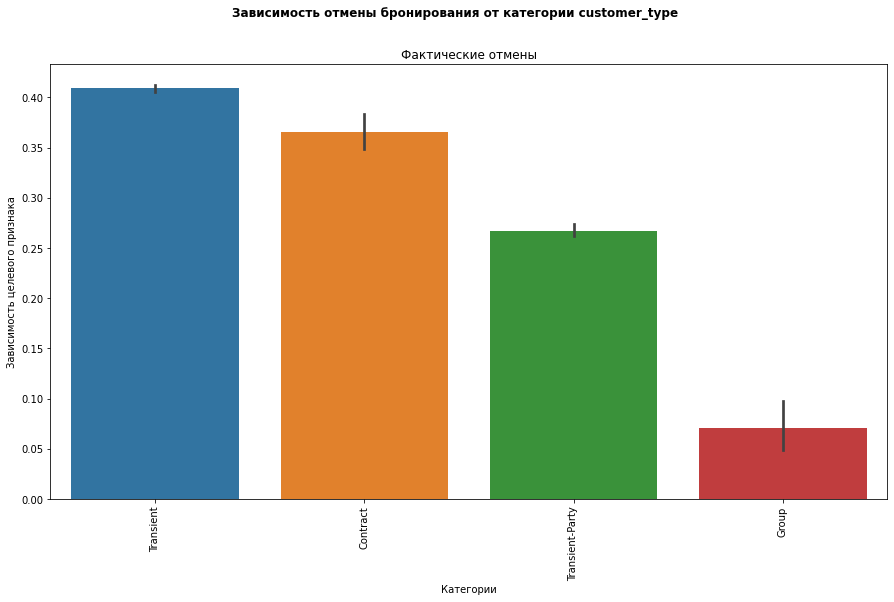

In [141]:
for i in categorized_cols:
    categories(i)

Чаще других отменяют клиенты типа `Transient`; наиболее отменяемые номера - самые дорогие. Также чаще отменяют заказы с полным рационом (meal = FB).

По странам посмотрим подробнее, ибо на графике из-за количества ничего не понятно.

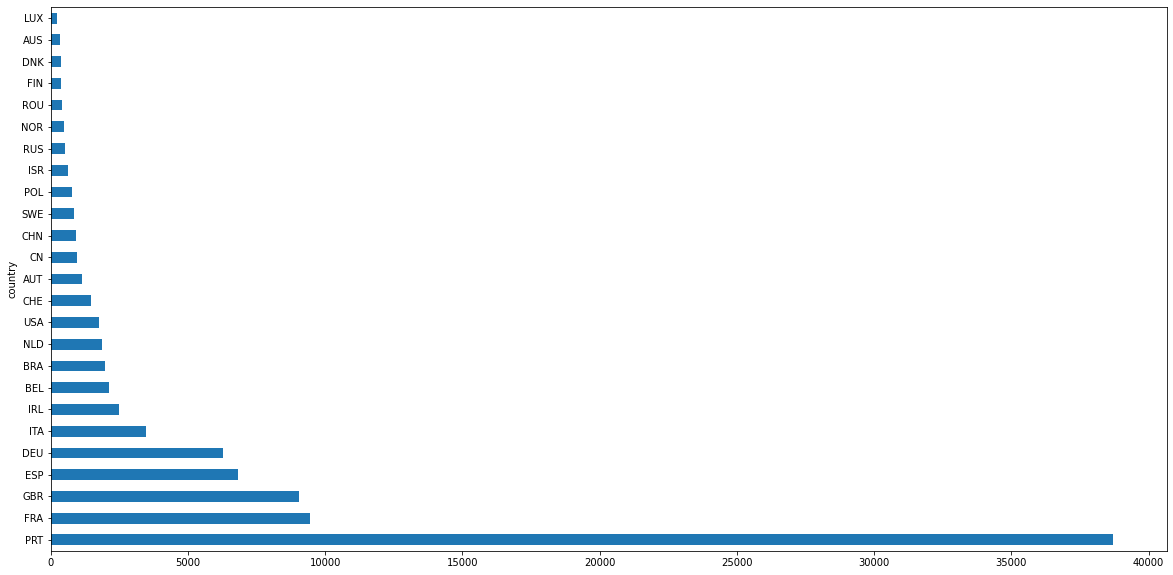

In [142]:
canceling.groupby('country')['is_canceled'].agg('count').sort_values(ascending=False).head(25).plot(kind='barh', figsize=(20, 10));

<AxesSubplot:>

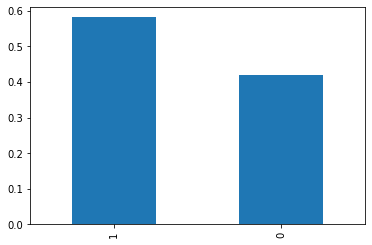

In [143]:
canceling.query('country == "PRT"')['is_canceled'].value_counts(normalize=True).plot(kind='bar')

Португальцы в 60% случаев отменяют заказы. Собственно, это было видно и в оценке веса признаков модели

# Общий вывод

На данных об отмене бронирования номеров отеля было проведено исследование возможности введения системы депозитов при бронировании.

*1.* Данные доступны за 2015—2017 гг.  
Пропусков и явных дубликатов в данных не обнаружено. Выявленые и устранены проблемы в виде некорректных значений, лишних для машинного обучения столбцов.

*2.* Данные исследованы. по результатам отмечено:
* процент отмен бронирования составляет ~37.5%;
* чаще других отменяют заказы на самые дорогие и самые дешевые номера;
* заказы из некоторых стран отменяются в 100% случаев;
* групповые заказы отменяют реже остальных.
 
*3.* Рассчитана бизнес-метрика — это прибыль.  
Суммарная прибыль по данным за три года составил 139 190 920.  
Разработана функция для расчета прибыли по предсказаниям модели.  

*4.* Обучены три модели - решающего дерева, леса деревьев и логистической регрессии.  
Каждой из них были подобраны оптимальные гиперпараметры, исходя из которых были оценены качества модели.  
Лучшие результаты показала модель случайного леса.  
С учетом бюждета на разработку модели машинного обучения в 400 000 была оценена прибыль после введения депозитной системы бронирования.
По результатам моделирования прибыль выросла.

*5.* Исследован портрет ненадежного клиента.  
Важнейшим признаком отмены заказа является время между заказом и заездом. Также чаще отменяют заказы дорогих номеров и полного рациона.  
Менее склонны к отмене постоянные клиенты (те, кто уже жил в отеле), клиенты со спецзапросами, групповые заказы.
Вероятность отмены заказа более 60% у граждан Португалии.  
Также высок шанс отмены французами, англичанами, испанцами и немцами.